# rsfMRI Preprocessing QA Notebook
---
Notebook for visualizing quality assurance outputs of the [Nipype resting state preprocessing script](https://github.com/gablab/openfmri/blob/openfmri/resting_state/rsfmri_vol_surface_preprocessing_nipy.py):
- registration (structural to MNI template: ANTS)
- ART outliers
- segmentation masks (produced by FAST; used during noise filtering (aCompCor))
- Topup (to be added)

The cells will display either brain slices or plots that allow for quick detection of potential problems. You must run the first 3 cells in order to use the rest of the notebook. 

You can also use this notebook to extract the average time series from specific aparc ROIs. 

See below for required packages.

(*updated Mar 14, 2017*)

In [1]:
%matplotlib inline

import os
import glob
import re
import fnmatch
import nilearn.plotting as nlp
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import pandas as pd
import seaborn as sns

import warnings

### Project-specific variables to change ###

In [8]:
rsfmri_dir = '/path/to/output/dir/'
subj_prefix = 'P'
subj_subset = ['P1280', 'P1378', 'P1474'] 
              # set to None to see all subjects
#with open(os.path.join(sublist_dir, 'list_of_subjects.txt')) as subj_list:
#    subj_subset=sublist.readlines()
#   subj_subset=map(str.strip.subj_subset) #use to read list from .txt file
outlier_threshold = 20    # percent 
ran_topup = False   # set to True if TOPUP was used

### Setting up subject list and # of vols for later use ###

In [4]:
def get_subjlist():
    if subj_subset == None:
        subjlist = [fl for fl in sorted(os.listdir(rsfmri_dir)) 
                    if fnmatch.fnmatch(fl, subj_prefix)]
    else:    
        subjlist = subj_subset
    return subjlist
    
def get_num_vols(subj):
    if ran_topup == True:
        rest_file = os.path.join(rsfmri_dir, subj, 'resting', 'timeseries', 'rest_01_roi_corrected.nii.gz')
    else:
        rest_file = os.path.join(rsfmri_dir, subj, 'resting', 'timeseries', 'rest_01.nii.gz')
    rest_img = nb.load(rest_file)
    return rest_img.shape[3]

# Registration #

In [5]:
def plot_anat(subj_path, title, fig=None, ax=None):
    anat2target = os.path.join(subj_path, 'resting', 'qa', 'ants', 'output_warped_image.nii.gz')
    close = False
    if ax is None:
        fig = plt.figure(figsize=(5, 2))
        ax = fig.gca()
        close = True
    display = nlp.plot_anat(anat_img=anat2target, cut_coords=(0, -13, 20), annotate=False,
                            draw_cross=False, title=title, figure=fig, axes=ax)
    if close:
        plt.show()
        display.close()

### Check registration of structural to MNI template ###

Displays cross-sections of the output of ANTS registration (the structural image warped to the MNI template).

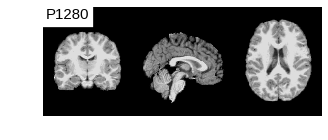

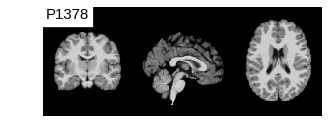

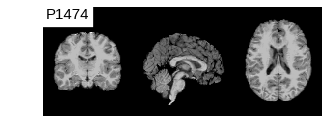

In [9]:
subjlist = get_subjlist()
for subj in subjlist:
    plot_anat(os.path.join(rsfmri_dir, subj), title=subj)

# Outliers #

In [10]:
def count_outliers(subj_path):
    if ran_topup == True:
        outlier_file = os.path.join(subj_path,'resting', 'qa', 'art', 
                                    'art.rest_01_roi_corrected_outliers.txt')
    else:
        outlier_file = os.path.join(subj_path,'resting', 'qa', 'art', 
                                    'art.rest_01_outliers.txt')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        outliers = np.genfromtxt(outlier_file)
    return np.prod(outliers.shape)

### Check percentage of outliers per run ###

Displays a heatmap of the percentage of outliers detected in the resting state time series. Darker = more outliers.

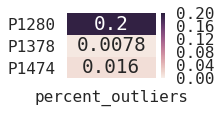

In [11]:
df = pd.DataFrame()
subjlist = get_subjlist()
for idx, subj in enumerate(subjlist):
    num_outliers = count_outliers(os.path.join(rsfmri_dir, subj)) 
    num_vols = get_num_vols(subj)
    perc_outliers = float(num_outliers)/num_vols
    df.set_value(subj, 'percent_outliers', perc_outliers)
    
sns.set(context="poster", font="monospace")
f, ax = plt.subplots(figsize=(2, 0.4*len(df.index)))
sns.heatmap(df, linewidths=0, annot=True, vmax=outlier_threshold/100., vmin=0)
outlier_df = df

### If you ran the previous cell and would like the outlier percentages outputted in csv form: ###

Indicate an output directory for the csv file below. 

In [12]:
csv_outdir = '/path/to/outdir/'  # USER OPTION

outlier_df.to_csv(os.path.join(csv_outdir, 'outlier_summary.csv'))

# Segmentation Masks #

In [13]:
def plot_mask_only(subj_path, title, fig=None, ax=None):
    anat2target = os.path.join(subj_path, 'resting', 'mask_files', 'native_brain_mask.nii.gz')
    close = False
    if ax is None:
        fig = plt.figure(figsize=(5, 2))
        ax = fig.gca()
        close = True
    display = nlp.plot_anat(anat_img=anat2target, display_mode= 'z', cut_coords=5, annotate=False,
                            draw_cross=False, title=title, figure=fig, axes=ax)
    if close:
        plt.show()
        display.close()
def plot_mask(subj_path, mask, title, fig=None, ax=None):
    bg = os.path.join(subj_path, 'resting', 'mask_files', 'native_brain_mask.nii.gz')
    close = False
    if ax is None:
        fig = plt.figure(figsize=(5, 2))
        ax = fig.gca()
        close = True
    display = nlp.plot_roi(roi_img=mask, bg_img=bg, black_bg=True, display_mode='ortho',
                           draw_cross=False, figure=fig, axes=ax, title=title)
    if close:
        plt.show()
        display.close()
    
def count_noise_regressors(subj_path):
    noise_components = pd.read_csv(os.path.join(subj_path, 'resting', 'regress', 
                                            '_makecompcorrfilter0', 'noise_components.txt'), 
                               delimiter=' ', header=None)
    num_noise_regressors = len(noise_components.columns)
    return num_noise_regressors

### Check the  functional image mask for areas of dropout

This was intended to show areas where the mask may not have caught the brain due to dropout. However, I'm not certain this is really telling us anything, given that alignment could be different across subjects. 

_(to be added/modified)_

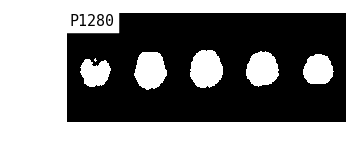

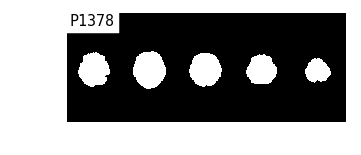

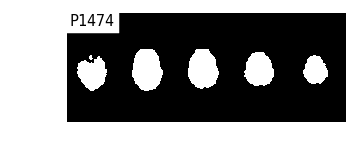

In [14]:
subjlist = get_subjlist()
for subj in subjlist:
    plot_mask_only(os.path.join(rsfmri_dir,subj),title=subj)

### Check that the CSF and WM masks were correctly segmented ###

Displays cross-sections of the segmentations (blue, binarized) produced by FSL's FAST tool, overlaid on a mask of the median functional image. Check to see if any of the segmentation masks are empty files.

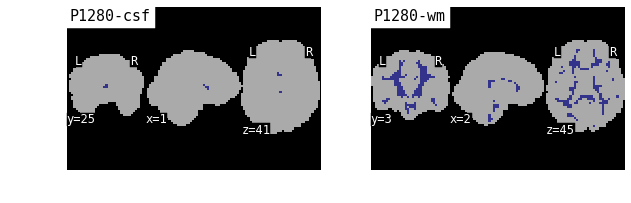

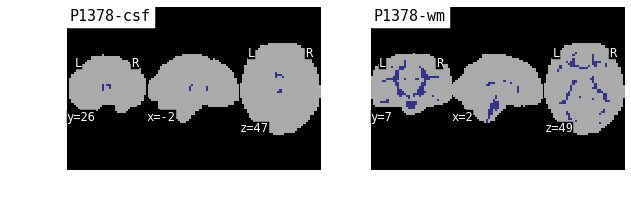

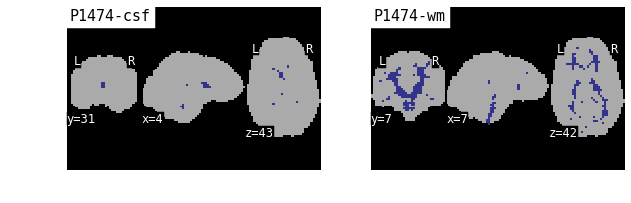

In [16]:
subjlist = get_subjlist()
for subj in subjlist:
    mask_dir = os.path.join(rsfmri_dir, subj, 'resting', 'mask_files')
    csf_mask = os.path.join(mask_dir, 'compcor_csf.nii.gz')
    wm_mask = os.path.join(mask_dir, 'compcor_wm.nii.gz')
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for i, seg in enumerate([(csf_mask, 'csf'), (wm_mask, 'wm')]):
        plot_mask(os.path.join(rsfmri_dir, subj), seg[0], subj+'-'+seg[1], fig=fig, ax=ax[i])
    plt.show()
    plt.close(fig)

### Check if GLM of noise components contains incorrect number of regressors (due to FAST breaking) ###

Supplement to the previous cell. If FAST did not produce the correct segmentations, the GLM used for regressing out physiological noise will not contain the expected number of noise components. This cell prints out any subjects that do not have the expected number.  

In [17]:
subjlist = get_subjlist()
for subj in subjlist:
    num_noise_regressors = count_noise_regressors(os.path.join(rsfmri_dir, subj))
    num_outliers = count_outliers(os.path.join(rsfmri_dir, subj))
    if 25 + num_outliers != num_noise_regressors:
        print subj

# Topup #

(To be added.)

---
# Extracting the average time series from aparc ROIs

The preprocessing script already does this (samples in functional space), but outputs all of the aparc ROIs together in a single file. The following cells can be used to help parse out the particular ROIs you're interested in.

**Note**: here we're sampling from the unsmoothed functional data; there is also smoothed data available.

Each subject output directory has a parcellations/aparc/rest_01_summary.stats file - check one of these files to see how the different FreeSurfer ROIs are named, and enter them into the roi_list variable below:

In [131]:
roi_list = ['ctx-lh-parsopercularis', 'ctx-rh-rostralmiddlefrontal']

The next cell will output a csv file containing the time series of each ROI given in roi_list, for each subject in your subjlist. Indicate an output directory for the csv file below. 

In [139]:
csv_outdir = '/path/to/csv/outdir/'   # USER OPTION

subjlist = get_subjlist()
for subj in subjlist:
    summary = pd.read_csv(os.path.join(rsfmri_dir, subj, 'resting', 'parcellations', 'aparc', 
                                       'rest_01_summary.stats'), 
                          header=None, comment='#', delim_whitespace=True, index_col=0)
    meants_df = pd.DataFrame()
    for roi in roi_list:
        roi_idx = summary[summary[4].str.contains(roi)].index.values
        meants = pd.read_csv(os.path.join(rsfmri_dir, subj, 'resting', 'parcellations', 'aparc', 
                                          'rest_01_avgwf.txt'), 
                             header=None, delim_whitespace=True, usecols=roi_idx-1, names=[roi])
        meants_df = pd.concat([meants_df, meants], axis=1)
    meants_df.to_csv(os.path.join(csv_outdir, '%s_rest_aparc_meants.csv' % subj), sep='\t', index=False)